In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import mat73
import numpy as np
from tqdm import tqdm
import wandb
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

from scipy.signal import find_peaks
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import r2_score
import psutil
import os
import time

In [2]:
wandb.login()
# run = wandb.init(project="master-multicomponent-mri", name="cnn-central-voxel")
run = wandb.init(project="master-multicomponent-mri", name="cnn-central-voxel-improved")

wandb: Currently logged in as: tr-phan (trphan) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [ ]:
data = mat73.loadmat('../../data/training_data_T1_3D_9x9x32x47932_noise0.05.mat')
input_noisy_np = data['input_noisy']
input_clean_np = data['input']
ref_np = data['ref']

print("Shape of input data:", input_noisy_np.shape)
print("Shape of reference data:", ref_np.shape)

Shape of input data: (9, 9, 8, 47932)
Shape of reference data: (9, 9, 32, 47932)


In [4]:
nan_count_input_noisy_before = np.isnan(input_noisy_np).sum()
nan_count_ref_before = np.isnan(ref_np).sum()
print(f"NaN count in input_noisy before handling: {nan_count_input_noisy_before}")
print(f"NaN count in ref before handling: {nan_count_ref_before}")

NaN count in input_noisy before handling: 1635840
NaN count in ref before handling: 0


In [5]:
input_noisy_np = np.nan_to_num(input_noisy_np, nan=0.0)
nan_count_input_noisy_after = np.isnan(input_noisy_np).sum()
print(f"NaN count in input_noisy after handling: {nan_count_input_noisy_after}")

NaN count in input_noisy after handling: 0


In [ ]:
print("Input shape:", input_noisy_np.shape)
print("Reference shape:", ref_np.shape)

Input shape: (9, 9, 8, 47932)
Reference shape: (9, 9, 32, 47932)


In [ ]:
class T1PatchDataset(Dataset):
    def __init__(self, input_data, target_data):
        self.input_data = input_data
        self.target_data = target_data[:, :, 4, 4]

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        return self.input_data[idx], self.target_data[idx]

In [ ]:
class CentralVoxelCNN(nn.Module):
    def __init__(self):
        super(CentralVoxelCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(8, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.LeakyReLU(0.1)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.LeakyReLU(0.1)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu3 = nn.LeakyReLU(0.1)
        
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        
        self.fc1 = nn.Linear(256, 128)
        self.fc_relu = nn.LeakyReLU(0.1)
        self.fc2 = nn.Linear(128, 32)

    def forward(self, x):
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.relu2(self.bn2(self.conv2(x)))
        x = self.relu3(self.bn3(self.conv3(x)))
        
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        
        x = self.fc_relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [ ]:
class EarlyStopping:
    def __init__(self, patience=15, min_delta=1e-6, path='saved_models/checkpoint.pt'):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.path = path
        
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.path)

In [ ]:
# Transpose the input and reference data to be (N, C, H, W) format
input_noisy_torch = np.transpose(input_noisy_np, (3, 2, 0, 1))
ref_torch = np.transpose(ref_np, (3, 2, 0, 1))

input_noisy_torch = torch.tensor(input_noisy_torch, dtype=torch.float32)
ref_torch = torch.tensor(ref_torch, dtype=torch.float32)

In [11]:
print("Input tensor shape:", input_noisy_torch.shape)
print("Reference tensor shape:", ref_torch.shape)

Input tensor shape: torch.Size([47932, 8, 9, 9])
Reference tensor shape: torch.Size([47932, 32, 9, 9])


In [ ]:
# Create Dataset
dataset = T1PatchDataset(input_noisy_torch, ref_torch)

# Split dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
sample_input, sample_target = dataset[0]
print("Sample input shape:", sample_input.shape)
print("Sample target shape:", sample_target.shape)

Sample input shape: torch.Size([8, 9, 9])
Sample target shape: torch.Size([32])


In [ ]:
# Training Setup 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CentralVoxelCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)
early_stopping = EarlyStopping(patience=15, path='best_cnn_model.pt')

num_epochs = 200

d:\Proton Drive\My files\Schule\Master\Masterarbeit\project\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [15]:
# Log configuration
wandb.config.update({
    "learning_rate": 0.001,
    "batch_size": batch_size,
    "epochs": num_epochs,
    "architecture": "CentralVoxelCNN",
    "optimizer": "Adam",
    "loss_function": "MSELoss",
    "scheduler": "ReduceLROnPlateau",
    "early_stopping_patience": 15
})

In [16]:
# Training loop
best_val_loss = float('inf')

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    progress_bar_train = tqdm(train_loader, desc=f'Epoch [{epoch+1}/{num_epochs}] Training')
    
    for inputs, targets in progress_bar_train:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        train_loss += loss.item()
        progress_bar_train.set_postfix({'loss': loss.item()})

    avg_train_loss = train_loss / len(train_loader)

    # Validation phase
    model.eval()
    val_loss = 0.0
    progress_bar_val = tqdm(val_loader, desc=f'Epoch [{epoch+1}/{num_epochs}] Validation')
    
    with torch.no_grad():
        for inputs, targets in progress_bar_val:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            progress_bar_val.set_postfix({'loss': loss.item()})

    avg_val_loss = val_loss / len(val_loader)

    # Learning rate scheduling
    scheduler.step(avg_val_loss)
    current_lr = optimizer.param_groups[0]['lr']

    # Early stopping
    early_stopping(avg_val_loss, model)

    # Logging
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss,
        "learning_rate": current_lr
    })

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}, LR: {current_lr}')

    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

print("Training finished")

Epoch [1/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 356.65it/s, loss=0.003]  


Epoch [1/200], Train Loss: 0.002963809575885534, Val Loss: 0.003171193703698615, LR: 0.001


Epoch [2/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 399.25it/s, loss=0.00531]


EarlyStopping counter: 1 out of 15
Epoch [2/200], Train Loss: 0.0025456567485040676, Val Loss: 0.005294607396547993, LR: 0.001


Epoch [3/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 352.13it/s, loss=0.00229]


Epoch [3/200], Train Loss: 0.002439268066858252, Val Loss: 0.0024661819729954004, LR: 0.001


Epoch [4/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 397.34it/s, loss=0.0027] 


EarlyStopping counter: 1 out of 15
Epoch [4/200], Train Loss: 0.0023795558698475362, Val Loss: 0.0028339844522997735, LR: 0.001


Epoch [5/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 377.17it/s, loss=0.00213]


Epoch [5/200], Train Loss: 0.002312479002090792, Val Loss: 0.0023011919398171206, LR: 0.001


Epoch [6/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 387.99it/s, loss=0.00231]


EarlyStopping counter: 1 out of 15
Epoch [6/200], Train Loss: 0.002281767266298023, Val Loss: 0.002400356864091009, LR: 0.001


Epoch [7/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 376.02it/s, loss=0.00226]


EarlyStopping counter: 2 out of 15
Epoch [7/200], Train Loss: 0.0022573133090433356, Val Loss: 0.0026105491925651828, LR: 0.001


Epoch [8/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 355.53it/s, loss=0.00213]


Epoch [8/200], Train Loss: 0.0022150456763726347, Val Loss: 0.0022681829946426054, LR: 0.001


Epoch [9/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 390.53it/s, loss=0.00218]


EarlyStopping counter: 1 out of 15
Epoch [9/200], Train Loss: 0.002201443048543297, Val Loss: 0.0025218217990671597, LR: 0.001


Epoch [10/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 365.94it/s, loss=0.00212]


EarlyStopping counter: 2 out of 15
Epoch [10/200], Train Loss: 0.0021719510205245266, Val Loss: 0.0022967683880900343, LR: 0.001


Epoch [11/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 338.35it/s, loss=0.00213]


EarlyStopping counter: 3 out of 15
Epoch [11/200], Train Loss: 0.0021553970355307683, Val Loss: 0.0022755646348620456, LR: 0.001


Epoch [12/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 375.14it/s, loss=0.00285]


EarlyStopping counter: 4 out of 15
Epoch [12/200], Train Loss: 0.0021298986421121905, Val Loss: 0.0029073171488319836, LR: 0.001


Epoch [13/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 350.28it/s, loss=0.00238]


EarlyStopping counter: 5 out of 15
Epoch [13/200], Train Loss: 0.0021034620323916895, Val Loss: 0.0026131172198802233, LR: 0.001


Epoch [14/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 347.99it/s, loss=0.00227]


EarlyStopping counter: 6 out of 15
Epoch [14/200], Train Loss: 0.0020983807160519065, Val Loss: 0.0024753436213359238, LR: 0.001


Epoch [15/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 362.72it/s, loss=0.00217]


EarlyStopping counter: 7 out of 15
Epoch [15/200], Train Loss: 0.0020788625792677825, Val Loss: 0.0024030123092234133, LR: 0.001


Epoch [16/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 328.20it/s, loss=0.00177]


Epoch [16/200], Train Loss: 0.0020649178275683275, Val Loss: 0.002052275164363285, LR: 0.001


Epoch [17/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 379.00it/s, loss=0.00222]


EarlyStopping counter: 1 out of 15
Epoch [17/200], Train Loss: 0.0020519772748230024, Val Loss: 0.002465109683107585, LR: 0.001


Epoch [18/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 363.80it/s, loss=0.00226]


EarlyStopping counter: 2 out of 15
Epoch [18/200], Train Loss: 0.0020404904564687363, Val Loss: 0.002399149208019177, LR: 0.001


Epoch [19/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 349.45it/s, loss=0.00186]


EarlyStopping counter: 3 out of 15
Epoch [19/200], Train Loss: 0.002026039866032079, Val Loss: 0.002239286305848509, LR: 0.001


Epoch [20/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 365.92it/s, loss=0.00168]


Epoch [20/200], Train Loss: 0.002009338223724626, Val Loss: 0.0020072407609162232, LR: 0.001


Epoch [21/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 362.76it/s, loss=0.00194]


EarlyStopping counter: 1 out of 15
Epoch [21/200], Train Loss: 0.0019926350336754695, Val Loss: 0.0020672335017782946, LR: 0.001


Epoch [22/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 364.03it/s, loss=0.00176]


EarlyStopping counter: 2 out of 15
Epoch [22/200], Train Loss: 0.001990419764770195, Val Loss: 0.002070311224864175, LR: 0.001


Epoch [23/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 366.02it/s, loss=0.00186]


EarlyStopping counter: 3 out of 15
Epoch [23/200], Train Loss: 0.001964899570836375, Val Loss: 0.002235096409761657, LR: 0.001


Epoch [24/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 354.30it/s, loss=0.00216]


EarlyStopping counter: 4 out of 15
Epoch [24/200], Train Loss: 0.0019656275315598276, Val Loss: 0.0022871769467989606, LR: 0.001


Epoch [25/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 376.67it/s, loss=0.00194]


EarlyStopping counter: 5 out of 15
Epoch [25/200], Train Loss: 0.001950851565343328, Val Loss: 0.0021779353528593977, LR: 0.001


Epoch [26/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 344.02it/s, loss=0.00198]


EarlyStopping counter: 6 out of 15
Epoch [26/200], Train Loss: 0.0019336041416196774, Val Loss: 0.002163294720618675, LR: 0.001


Epoch [27/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 371.36it/s, loss=0.00168]


EarlyStopping counter: 7 out of 15
Epoch [27/200], Train Loss: 0.001928602296199339, Val Loss: 0.0020612311378742257, LR: 0.001


Epoch [28/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 366.28it/s, loss=0.00179]


EarlyStopping counter: 8 out of 15
Epoch [28/200], Train Loss: 0.0019121758952193584, Val Loss: 0.002030366053028653, LR: 0.001


Epoch [29/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 362.77it/s, loss=0.00166]


EarlyStopping counter: 9 out of 15
Epoch [29/200], Train Loss: 0.001898663128959015, Val Loss: 0.002028367515498151, LR: 0.001


Epoch [30/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 375.06it/s, loss=0.00184]


EarlyStopping counter: 10 out of 15
Epoch [30/200], Train Loss: 0.0018854567053494975, Val Loss: 0.0020416036069703597, LR: 0.001


Epoch [31/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 376.21it/s, loss=0.00166]


EarlyStopping counter: 11 out of 15
Epoch [31/200], Train Loss: 0.0018828419035223003, Val Loss: 0.0020567401389901836, LR: 0.0005


Epoch [32/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 349.58it/s, loss=0.0019] 


EarlyStopping counter: 12 out of 15
Epoch [32/200], Train Loss: 0.0017984312941553072, Val Loss: 0.002062102246563882, LR: 0.0005


Epoch [33/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 358.76it/s, loss=0.00166]


Epoch [33/200], Train Loss: 0.001777612137569425, Val Loss: 0.0019105448240103822, LR: 0.0005


Epoch [34/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 371.52it/s, loss=0.00178]


EarlyStopping counter: 1 out of 15
Epoch [34/200], Train Loss: 0.0017657588437820474, Val Loss: 0.0019787082937546075, LR: 0.0005


Epoch [35/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 374.58it/s, loss=0.00154]


EarlyStopping counter: 2 out of 15
Epoch [35/200], Train Loss: 0.0017522084802233924, Val Loss: 0.001956563281516234, LR: 0.0005


Epoch [36/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 368.04it/s, loss=0.00168]


EarlyStopping counter: 3 out of 15
Epoch [36/200], Train Loss: 0.0017424363976654908, Val Loss: 0.0019150670097830395, LR: 0.0005


Epoch [37/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 367.37it/s, loss=0.00182]


EarlyStopping counter: 4 out of 15
Epoch [37/200], Train Loss: 0.001732029581714111, Val Loss: 0.002009929805062711, LR: 0.0005


Epoch [38/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 368.08it/s, loss=0.00154]


EarlyStopping counter: 5 out of 15
Epoch [38/200], Train Loss: 0.0017192787723615765, Val Loss: 0.0020189201831817627, LR: 0.0005


Epoch [39/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 330.22it/s, loss=0.00179]


EarlyStopping counter: 6 out of 15
Epoch [39/200], Train Loss: 0.001707538822083734, Val Loss: 0.0020774403975034753, LR: 0.0005


Epoch [40/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 300.89it/s, loss=0.00167]


EarlyStopping counter: 7 out of 15
Epoch [40/200], Train Loss: 0.0016966568071317548, Val Loss: 0.0019143693133567771, LR: 0.0005


Epoch [41/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 362.72it/s, loss=0.00165]


EarlyStopping counter: 8 out of 15
Epoch [41/200], Train Loss: 0.0016906949825352057, Val Loss: 0.001968431448719154, LR: 0.0005


Epoch [42/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 359.32it/s, loss=0.00166]


EarlyStopping counter: 9 out of 15
Epoch [42/200], Train Loss: 0.001682342097046785, Val Loss: 0.0019282480267186959, LR: 0.0005


Epoch [43/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 362.05it/s, loss=0.00177]


EarlyStopping counter: 10 out of 15
Epoch [43/200], Train Loss: 0.0016706252685980871, Val Loss: 0.0020720713182042043, LR: 0.0005


Epoch [44/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 364.39it/s, loss=0.00206]


EarlyStopping counter: 11 out of 15
Epoch [44/200], Train Loss: 0.0016558647776643435, Val Loss: 0.0022041086774940294, LR: 0.00025


Epoch [45/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 363.65it/s, loss=0.00169]


EarlyStopping counter: 12 out of 15
Epoch [45/200], Train Loss: 0.0015880166648033385, Val Loss: 0.0019142010776946941, LR: 0.00025


Epoch [46/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 365.36it/s, loss=0.0016] 


EarlyStopping counter: 13 out of 15
Epoch [46/200], Train Loss: 0.0015778343965454648, Val Loss: 0.0019260060717351734, LR: 0.00025


Epoch [47/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 359.40it/s, loss=0.00169]


EarlyStopping counter: 14 out of 15
Epoch [47/200], Train Loss: 0.001567975948176657, Val Loss: 0.0019304316832373539, LR: 0.00025


Epoch [48/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 371.45it/s, loss=0.00158]

EarlyStopping counter: 15 out of 15
Epoch [48/200], Train Loss: 0.0015573535133929302, Val Loss: 0.0019270573385680716, LR: 0.00025
Early stopping triggered
Training finished


In [17]:
# Load the saved model
# model.load_state_dict(torch.load('best_cnn_model.pt'))
# model.eval()

In [18]:
def calculate_psnr(target, prediction):
    """Calculate Peak Signal-to-Noise Ratio"""
    mse = np.mean((target - prediction) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = np.max(target)
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

def calculate_peak_metrics(target, prediction, prominence=0.1):
    """Calculate peak detection accuracy"""
    peak_metrics = {'true_peaks': 0, 'predicted_peaks': 0, 'matching_peaks': 0}
    
    for i in range(len(target)):
        true_peaks, _ = find_peaks(target[i], prominence=prominence)
        pred_peaks, _ = find_peaks(prediction[i], prominence=prominence)
        
        # Count matching peaks (within ±1 index)
        matches = 0
        for tp in true_peaks:
            for pp in pred_peaks:
                if abs(tp - pp) <= 1:
                    matches += 1
                    break
        
        peak_metrics['true_peaks'] += len(true_peaks)
        peak_metrics['predicted_peaks'] += len(pred_peaks)
        peak_metrics['matching_peaks'] += matches
    
    return peak_metrics

def measure_inference_time(model, input_tensor, device, num_iterations=100):
    """Measure average inference time"""
    model.eval()
    start_time = time.time()
    with torch.no_grad():
        for _ in range(num_iterations):
            _ = model(input_tensor.to(device))
    end_time = time.time()
    return (end_time - start_time) / num_iterations

def count_parameters(model):
    """Count number of trainable parameters"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def measure_memory_usage():
    """Measure current memory usage"""
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 / 1024  # Convert to MB

def evaluate_model_metrics(model, val_loader, device):
    """Evaluate all model metrics"""
    model.eval()
    metrics = {}
    
    # Get sample input for inference time measurement
    sample_input, _ = next(iter(val_loader))
    metrics['inference_time'] = measure_inference_time(model, sample_input, device)
    
    all_targets = []
    all_predictions = []
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            
            # Convert to numpy for metric calculation
            targets_np = targets.cpu().numpy()
            outputs_np = outputs.cpu().numpy()
            
            all_targets.append(targets_np)
            all_predictions.append(outputs_np)
    
    # Concatenate all batches
    all_targets = np.concatenate(all_targets)
    all_predictions = np.concatenate(all_predictions)
    
    # Calculate metrics
    metrics['mse'] = np.mean((all_targets - all_predictions) ** 2)
    metrics['mae'] = np.mean(np.abs(all_targets - all_predictions))
    metrics['psnr'] = calculate_psnr(all_targets, all_predictions)
    metrics['r2_score'] = r2_score(all_targets.flatten(), all_predictions.flatten())
    metrics['peak_metrics'] = calculate_peak_metrics(all_targets, all_predictions)
    metrics['memory_usage'] = measure_memory_usage()
    metrics['num_parameters'] = count_parameters(model)
    
    return metrics

In [ ]:
model.eval()
final_metrics = evaluate_model_metrics(model, val_loader, device)

wandb.log({
    "final_mse": final_metrics['mse'],
    "final_mae": final_metrics['mae'],
    "final_psnr": final_metrics['psnr'],
    "final_r2_score": final_metrics['r2_score'],
    "peak_detection_accuracy": final_metrics['peak_metrics']['matching_peaks'] / 
                             final_metrics['peak_metrics']['true_peaks'],
    "inference_time_ms": final_metrics['inference_time'] * 1000,
    "memory_usage_mb": final_metrics['memory_usage'],
    "model_parameters": final_metrics['num_parameters']
})

print("\nFinal Model Evaluation:")
print(f"MSE: {final_metrics['mse']:.6f}")
print(f"MAE: {final_metrics['mae']:.6f}")
print(f"PSNR: {final_metrics['psnr']:.2f} dB")
print(f"R² Score: {final_metrics['r2_score']:.4f}")
print(f"Peak Detection Accuracy: {final_metrics['peak_metrics']['matching_peaks'] / final_metrics['peak_metrics']['true_peaks']:.2%}")
print(f"Average Inference Time: {final_metrics['inference_time']*1000:.2f} ms")
print(f"Memory Usage: {final_metrics['memory_usage']:.1f} MB")
print(f"Number of Parameters: {final_metrics['num_parameters']:,}")


Final Model Evaluation:
MSE: 0.001928
MAE: 0.023870
PSNR: 26.72 dB
R² Score: 0.5476
Peak Detection Accuracy: 46.63%
Average Inference Time: 0.95 ms
Memory Usage: 2329.7 MB
Number of Parameters: 411,616


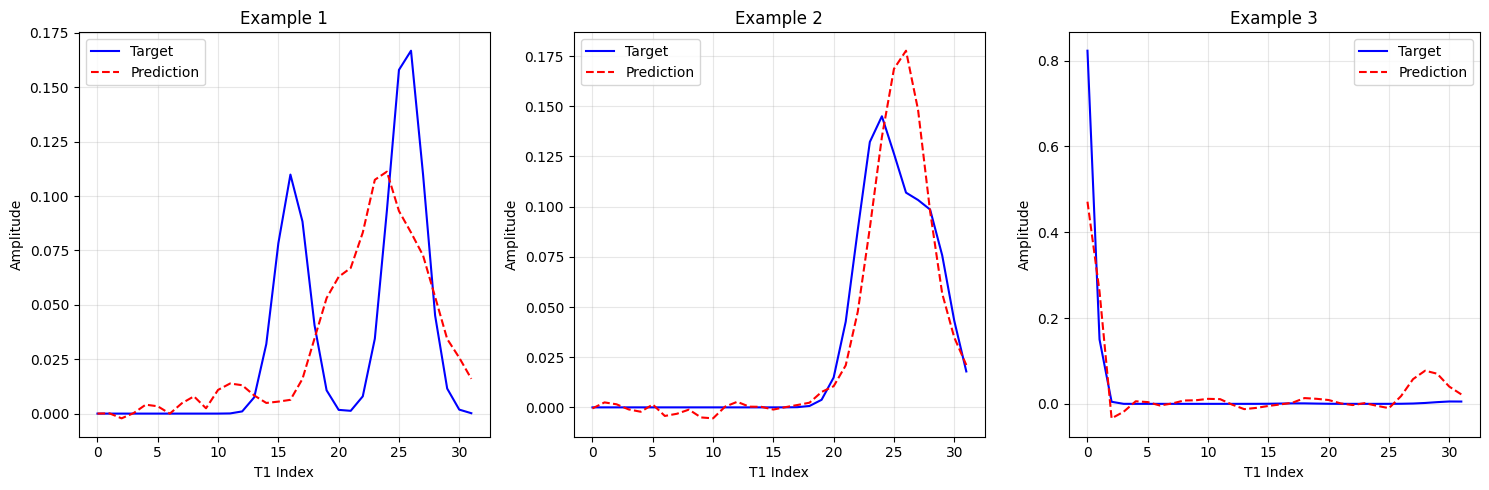

Test MSE: 0.001954
Test MAE: 0.023564


In [ ]:
inputs, targets = next(iter(val_loader))
inputs, targets = inputs.to(device), targets.to(device)

with torch.no_grad():
    outputs = model(inputs)

inputs = inputs.cpu().numpy()
targets = targets.cpu().numpy()
outputs = outputs.cpu().numpy()

plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.plot(targets[i], 'b-', label='Target')
    plt.plot(outputs[i], 'r--', label='Prediction')
    plt.title(f'Example {i+1}')
    plt.xlabel('T1 Index')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

mse = np.mean((targets - outputs)**2)
mae = np.mean(np.abs(targets - outputs))
print(f"Test MSE: {mse:.6f}")
print(f"Test MAE: {mae:.6f}")

In [21]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
final_mae,▁
final_mse,▁
final_psnr,▁
final_r2_score,▁
inference_time_ms,▁
learning_rate,█████████████████████████▃▃▃▃▃▃▃▃▃▃▃▁▁▁▁
memory_usage_mb,▁
model_parameters,▁
peak_detection_accuracy,▁
train_loss,█▆▅▅▅▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁
